c:\users\florian\appdata\local\programs\python\python36\lib\site-packages\pyVHR\signals\video.py:71: UserWarning:


WARNING!! Requested detector method is different from the saved one




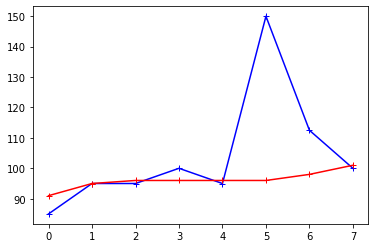

In [53]:
##
## Importing libraries
##

#Tensorflow/KERAS
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.utils import np_utils

# Numpy / Matplotlib / OpenCV / Scipy / Copy / ConfigParser
import numpy as np
import scipy.io
import scipy.stats as sp
import matplotlib.pyplot as plt
import cv2
from copy import copy
import os
import configparser

#pyVHR
from pyVHR.signals.video import Video
from pyVHR.datasets.dataset import Dataset
from pyVHR.datasets.dataset import datasetFactory

##
## Loading configuration
##

config = configparser.ConfigParser()

config.read('./testOnRealVideo.cfg')

if(int(config['ExeConfig']['useCPU']) == 1):
    #RUN ON CPU
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

##
## Loading the video & pyVHR processing
##

def extraction_roi(video_filename):
    video = Video(video_filename)
    video.getCroppedFaces(detector='dlib', extractor='skvideo')
    video.setMask(typeROI='skin_adapt',skinThresh_adapt=0.30)
    return video

##
## Loading the model
##

def loadmodel(model_path):
    model = model_from_json(open(f'{model_path}/model_conv3D.json').read())
    model.load_weights(f'{model_path}/weights_conv3D.h5')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # define the frequencies // output dimension (number of classes used during training)
    freq_bpm = np.linspace(55, 240, num=model.output_shape[1]-1)
    freq_bpm = np.append(freq_bpm, -1)     # noise class
    return model, freq_bpm

##
## Converting videoframes to a single channel array
##

def convert_video_to_table(video,model, start_frame):
    imgs = np.zeros(shape=(model.input_shape[1], video.cropSize[0], video.cropSize[1], 1))

    # channel extraction
    if (video.cropSize[2]<3):
        IMAGE_CHANNELS = 1
    else:
        IMAGE_CHANNELS = video.cropSize[2]

    # load images (imgs contains the whole video)
    for j in range(0, model.input_shape[1]):

        if (IMAGE_CHANNELS==3):
            temp = video.faces[j + start_frame]/255
            temp = temp[:,:,1]      # only the G component is currently used
        else:
            temp = video.faces[j + start_frame] / 255

        imgs[j] = np.expand_dims(temp, 2)
    return imgs

##
## Making a prediction
##

def get_prediction(model,freq_bpm, xtest):
    idx = 0
    # model.predict
    input_tensor = tf.convert_to_tensor(np.expand_dims(xtest, 0))
    h = model(input_tensor)
    h = h.numpy() 
    #Binary prediction
    res = np.zeros(shape=(76))
    idx = get_idx(h[0])
    res[idx] = 1
    return res

##
## Formating Video
##

def formating_data_test(video, model, imgs , freq_bpm, step_x, step_y):
    
    # output - sum of predictions
    predictions = np.zeros(shape=(len(freq_bpm)))
    
    # Displacement on the x axis
    iteration_x = 0
    # Our position at n + 1 on the X axis
    axis_x = model.input_shape[3]
    
    # width of video
    width = video.cropSize[1]
    # height of video
    height = video.cropSize[0]
    
    # Browse the X axis
    while axis_x < width:
        # Displacement on the y axis
        axis_y = model.input_shape[2]
        # Our position at n + 1 on the Y axis
        iteration_y = 0
        # Browse the Y axis
        while axis_y < height:
            
            # Start position
            x1 = iteration_x * step_x
            y1 = iteration_y * step_y
            
            # End position
            x2 = x1 + model.input_shape[3]
            y2 = y1 + model.input_shape[2]
            
            # Cutting 
            face_copy = copy(imgs[0:model.input_shape[1],x1:x2,y1:y2,:])
            
            # randomize pixel locations
            for j in range(model.input_shape[1]):
                temp = copy(face_copy[j,:,:,:])
                np.random.shuffle(temp)
                face_copy[j] = temp
            
            # Checks the validity of cutting
            if(np.shape(face_copy)[1] == model.input_shape[3] and np.shape(face_copy)[2] == model.input_shape[2]):
                # prediction on the cut part
                xtest = face_copy - np.mean(face_copy)
                predictions = predictions + get_prediction(model,freq_bpm,xtest)
            
            # increments
            axis_y = y2 + model.input_shape[2]
            iteration_y = iteration_y +1
        # increments    
        axis_x = x2 + model.input_shape[3]
        iteration_x = iteration_x + 1
        
    return predictions                
    
##
## Finding the label associated with the prediction
##

def get_class(h, freq_bpm, interval): 
    # index in the list
    iterator = 0
    # maximum value of an interval
    sum_max = -1
    # index of maximum value of an interval
    idx_max = 0
    # security against list out of range problems
    out_of_range = len(freq_bpm) -1
    
    # Calculating the sum of all intervals
    while iterator < (len(h)- interval - 1):
        # value of studied interval
        sum_interval = 0
        # representative index of value of studied interval
        idx_interval = iterator+ int(interval/2)
        
        # Calculates variables
        for j in range(interval):
            sum_interval = sum_interval + h[iterator + j]
        
        # Case where value of the studied interval equal to the value of the maximum interval
        if sum_interval == sum_max and sum_interval != 0:
            # Decision based on representative indexes
            if(h[idx_interval] > h[idx_max]):
                sum_max = sum_interval
                idx_max = idx_interval
            # Decision based on neighbors of representative indexes    
            elif(h[idx_interval] == h[idx_max]):
                sum_max, idx_max = study_neighborhoods(h, sum_max,sum_interval, idx_max, idx_interval, out_of_range)

        # Case where the studied interval is better than the maximum interval                
        elif (sum_interval > sum_max):
            sum_max = sum_interval
            idx_max = idx_interval
        #increment    
        iterator = iterator +1
        
    # return bpm value   
    return freq_bpm[idx_max] 
##
## Decision based on neighbors of representative indexes  
##
def study_neighborhoods(h, sum_max,sum_interval, idx_max, idx_interval, out_of_range):
    # Decision statue
    find = False
    # Neighborhood degree
    var = 1
    # intervals according to the degree of neighborhood
    sum_var_max = h[idx_max]
    sum_var_interval = h[idx_interval]
                
    # Study of neighborhood intervals
    while find is not True:
                    
        if(idx_interval + var < out_of_range):
            sum_var_interval = sum_var_interval + h[idx_interval + var]
            
        if(idx_interval - var >= 0):
            sum_var_interval = sum_var_interval + h[idx_interval - var]
            
        if(idx_max + var < out_of_range):
            sum_var_max = sum_var_max + h[idx_max + var]
            
        if(idx_max - var >= 0):
            sum_var_max = sum_var_max + h[idx_max - var]
                       
        if(sum_var_max < sum_var_interval):
            sum_max = sum_interval
            idx_max = idx_interval
            find =True
        elif(sum_var_max > sum_var_interval):
            find =True
  
        if(var > 10):
            find = True  
        else :
            var = var + 1
        
    return sum_max, idx_max

##
## Get the index of the maximum value of a prediction
##
def get_idx(h):
    idx =0
    maxi = -1
    #find label associated
    for i in range(0, len(h)):
        if maxi < h[i]:
            idx = i
            maxi = h[i]
    return idx   

##
## Make a prediction
##

def make_prediction(video, model, freq_bpm, start_frame):
    
    #extract Green channel or Black & whrite channel
    frames_one_channel = convert_video_to_table(video,model, start_frame)
    
    #Data preparation 
    x_step = int(config['DataConfig']['Xstep'])
    y_step = int(config['DataConfig']['Ystep'])
    prediction = formating_data_test(video, model, frames_one_channel, freq_bpm, x_step, y_step)
    
    # get bpm
    interval_for_estimation =  int(config['DataConfig']['intervalForEstimation'])
    bpm = get_class(prediction, freq_bpm, interval_for_estimation)
    return bpm


##
## Getting Ground truth
##
def get_gt(name_dataset, video_gt_filename, win_size_gt, freq_bpm):
    dataset = datasetFactory(name_dataset)
    sig_gt = dataset.readSigfile(video_gt_filename)
    bpm_gt, times_gt = sig_gt.getBPM(win_size_gt)
    return bpm_gt

##
## MAIN
##

videoFilename = str(config['ExeConfig']['videoFilename'])  #video to be processed path
modelFilename = str(config['ExeConfig']['modelFilename'])   #model path 

# ROI EXTRACTION
video = extraction_roi(videoFilename)
# Load the model
model, freq_bpm = loadmodel(modelFilename)

frameRate = int(config['DataConfig']['frameRate'])
nameDataset = str(config['ExeConfig']['nameDataset'])
videoGTFilename = str(config['ExeConfig']['videoGTFilename'])
winSizeGT = int(config['DataConfig']['winSizeGT'])

NB_LAPSE = int(video.numFrames / frameRate)
if(int(config['ExeConfig']['useNbLapse']) == 1):
    NB_LAPSE = int(config['DataConfig']['NbLapse'])
    
GT_BPM  = get_gt(nameDataset, videoGTFilename, winSizeGT, freq_bpm)

# tables for display
Tab_BPM_estimated = []
Tab_BPM_True = []
Tab_Lapse = []

# Second-by-second estimation
for lapse in range(0 ,NB_LAPSE):
    
    startFrame = lapse * frameRate

    end = startFrame + model.input_shape[1]
    if(end > video.numFrames):
        break

    BPM_estimated = make_prediction(video, model, freq_bpm, startFrame)
    Tab_BPM_estimated.append(BPM_estimated)
    BPM_True = int(GT_BPM[lapse+int(winSizeGT/2)])
    Tab_BPM_True.append(BPM_True)
    Tab_Lapse.append(lapse)

# Graphic display
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(np.asarray(Tab_Lapse), np.asarray(Tab_BPM_estimated), marker='+', color='blue', label='BPM ESTIMATES')
ax.plot(np.asarray(Tab_Lapse), np.asarray(Tab_BPM_True), marker='+', color='red', label='BPM GT')
plt.show()

In [54]:
print(Tab_BPM_estimated)

[85.0, 95.0, 95.0, 100.0, 95.0, 150.0, 112.5, 100.0]


In [55]:
print(Tab_BPM_True)

[91, 95, 96, 96, 96, 96, 98, 101]
